In [1]:
import numpy as np
import os
import sys
import pandas as pd
from dateutil import parser
import scipy.sparse
from scipy import stats
import datetime
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

from dimredu.denseSolvers import denseToSparse as denseToSparse
from dimredu.sRPCAviaADMMFast import sRPCA as sRPCA

In [9]:
def get_scaled_lambda(m, n, _lambda):
    lam = 1. / np.sqrt(np.max([m, n]))
    return lam * _lambda

def get_full_path_2_save(root_dir, filename):
    full_path = os.path.join(root_dir, filename)    
    return full_path

def get_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\kl-divergence\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\kl-divergence\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\kl-divergence\test'
    return output_root_dir

def get_asymmetrical_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\asymmetrical-kl-divergence\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\asymmetrical-kl-divergence\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\asymmetrical-kl-divergence\test'
    return output_root_dir

def get_asymmetrical_21_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\asymmetrical-21-kl-divergence\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\asymmetrical-21-kl-divergence\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\asymmetrical-21-kl-divergence\test'
    return output_root_dir

def get_symmetrical_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\symmetrical-kl-divergence\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\symmetrical-kl-divergence\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\symmetrical-kl-divergence\test'
    return output_root_dir

def get_input_dataset(df):
    err = np.ones(df.shape)*1e-6
    m, n, u, v, vecM, vecEpsilon = denseToSparse(df, err)
    maxRank = np.min(df.shape)
    nrows = df.shape[0]
    ncols = df.shape[1]
    return nrows, ncols, maxRank, m, n, u, v, vecM, vecEpsilon

def get_H(data, log_data):    
    rows = len(data)
    cols = rows
    H = np.zeros((rows, cols))
    
    for i in range(0, rows):
        Pi = data.iloc[i]
        log_Pi = log_data.iloc[i]
        pii = sum(Pi * log_Pi)

        for j in range(0, cols):
            if i == j:
                H[i, j] = 0
            else:
                Pj = data.iloc[j]
                log_Pj = log_data.iloc[j]
                Hij = 0.0
                pjj = sum(Pj * log_Pj)
                pij = sum(Pi * log_Pj)
                pji = sum(Pj * log_Pi)
                Hij = pii + pjj - pij - pji
                H[i, j] = Hij
    return H                        

def calculate_symmetrical_H(data, log_data):    
    rows = len(data)
    H = np.zeros((rows, rows)) 
    for i in np.arange(rows):
        for j in np.arange(rows):
            H[i,j] = stats.entropy(data.iloc[i], data.iloc[j]) + stats.entropy(data.iloc[j], data.iloc[i])     
    return H    

## KL Divergence with RPCA

In [3]:
df_new = pd.read_csv(r'C:\phd\rpca\input\kl-divergence\sp500_constituents_probabilities.csv')
df_new.set_index(df_new['Dates'], inplace=True)
df_new.drop('Dates', axis=1, inplace=True)
# df_new.dropna(axis=1, inplace=True)

Prepare training, validation and test set.  The training set uses 66% of the sample.  Validation set uses 17% and Test set uses the remaining 17% of the instances.

In [7]:
split_pct = 0.66
validation_pct = 0.17
training_set_end_idx = int(df_new.shape[0] * split_pct)
validation_set_end_idx = int(df_new.shape[0] * (split_pct+ validation_pct))

m_training_kl = df_new[0:training_set_end_idx].copy()
m_validation_kl = df_new[training_set_end_idx:validation_set_end_idx].copy()
m_test_kl = df_new[validation_set_end_idx:].copy()

In [39]:
m_training_kl.dropna(axis=1, inplace=True)
symmetrical_H_training = calculate_symmetrical_H(m_training_kl, np.log(m_training_kl))
symmetrical_H_training.dump(r'C:\phd\rpca\input\kl-divergence\symmetrical_H_training.dat')

In [41]:
m_validation_kl.dropna(axis=1, inplace=True)
symmetrical_H_validation = calculate_symmetrical_H(m_validation_kl, np.log(m_validation_kl))
symmetrical_H_validation.dump(r'C:\phd\rpca\input\kl-divergence\symmetrical_H_validation.dat')

In [42]:
m_test_kl.dropna(axis=1, inplace=True)
symmetrical_H_test = calculate_symmetrical_H(m_test_kl, np.log(m_test_kl))
symmetrical_H_test.dump(r'C:\phd\rpca\input\kl-divergence\symmetrical_H_test.dat')

#### Generate Asymmetrical H

In [5]:
def get_asymmetrical_H(data, log_data):    
    rows = len(data)
    cols = rows
    H = np.zeros((rows, cols))
    
    for i in range(0, rows):
        Pi = data.iloc[i]
        log_Pi = log_data.iloc[i]
        pii = sum(Pi * log_Pi)

        for j in range(0, cols):
            if i == j:
                H[i, j] = 0
            else:
                Pj = data.iloc[j]
                log_Pj = log_data.iloc[j]
                Hij = 0.0
                pij = sum(Pi * log_Pj)
                Hij = pii - pij
                H[i, j] = Hij
    return H  

def calculate_asymmetrical_H(data):    
    rows = len(data)
    H = np.zeros((rows, rows)) 
    for i in np.arange(rows):
        for j in np.arange(rows):
            H[i,j] = stats.entropy(data.iloc[i], data.iloc[j]) 
    return H    

def calculate_asymmetrical_H21(data):    
    rows = len(data)
    H = np.zeros((rows, rows)) 
    for i in np.arange(rows):
        for j in np.arange(rows):
            H[i,j] = stats.entropy(data.iloc[j], data.iloc[i]) 
    return H    

#### Reverse Asymmetrical H

In [45]:
m_training_kl.dropna(axis=1, inplace=True)
asymmetrical_H_training = calculate_asymmetrical_H(m_training_kl)
asymmetrical_H_training.dump(r'C:\phd\rpca\input\kl-divergence\asymmetrical_H_training.dat')

m_validation_kl.dropna(axis=1, inplace=True)
asymmetrical_H_validation = calculate_asymmetrical_H(m_validation_kl)
asymmetrical_H_validation.dump(r'C:\phd\rpca\input\kl-divergence\asymmetrical_H_validation.dat')

m_test_kl.dropna(axis=1, inplace=True)
asymmetrical_H_test = calculate_asymmetrical_H(m_test_kl)
asymmetrical_H_test.dump(r'C:\phd\rpca\input\kl-divergence\asymmetrical_H_test.dat')

#### Calculate Reverse Asymmetrical H 21

In [8]:
m_training_kl.dropna(axis=1, inplace=True)
asymmetrical_H21_training = calculate_asymmetrical_H21(m_training_kl)
asymmetrical_H21_training.dump(r'C:\phd\rpca\input\kl-divergence\asymmetrical_H21_training.dat')

m_validation_kl.dropna(axis=1, inplace=True)
asymmetrical_H21_validation = calculate_asymmetrical_H21(m_validation_kl)
asymmetrical_H21_validation.dump(r'C:\phd\rpca\input\kl-divergence\asymmetrical_H21_validation.dat')

m_test_kl.dropna(axis=1, inplace=True)
asymmetrical_H21_test = calculate_asymmetrical_H21(m_test_kl)
asymmetrical_H21_test.dump(r'C:\phd\rpca\input\kl-divergence\asymmetrical_H21_test.dat')

#### Create Asymmetrical 21 Intermediate files

In [11]:
dataset_types = ["training", "validation", "test"]

# RPCA parameters for experiments
maxIteration = 1000
verbose = True

for dataset_type in dataset_types:
    df = None
    if "training" == dataset_type:
        print("%s - using asymmetrical_H21_training" % dataset_type)
        df = asymmetrical_H21_training
    elif "validation" == dataset_type:
        print("%s - using asymmetrical_H21_validation" % dataset_type)
        df = asymmetrical_H21_validation
    else:
        print("%s - using asymmetrical_H21_test" % dataset_type)
        df = asymmetrical_H21_test

    nrows, ncols, maxRank, m, n, u, v, vecM, vecEpsilon = get_input_dataset(df)
    print("get_input_dataset returned nrows = %d, ncols = %d, maxRank = %d" % (nrows, ncols, maxRank))
    
    for lambda_multiplier in lam_list:    
        actual_lambda = get_scaled_lambda(nrows, ncols, lambda_multiplier)
        print('Now processing lambda multiplier = %4f and actual lambda = %5f' % (lambda_multiplier, actual_lambda))

        output_root_dir = get_asymmetrical_21_output_root_dir(dataset_type)
        print("output_root_dir = %s" % output_root_dir)
                
        U, E, VT, S, B = sRPCA(m, n, u, v, vecM, vecEpsilon, maxRank, 
                           lam=actual_lambda, mu=None, rho=None, 
                           epsilon1=None, epsilon2=None, 
                           truncateK=0, SOff=False, maxIteration=maxIteration, verbose=verbose)
        filename_prefix = r"lambda_" + str(lambda_multiplier)
        U.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_U.dat'))
        E.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_E.dat'))
        VT.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_VT.dat'))
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_S.npz'), S) # compressed matrix
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_B.npz'), B) # compressed matrix

training - using asymmetrical_H21_training
get_input_dataset returned nrows = 1954, ncols = 1954, maxRank = 1954
Now processing lambda multiplier = 0.050000 and actual lambda = 0.001131
output_root_dir = C:\phd\rpca\output\asymmetrical-21-kl-divergence\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   1.60e-02 1.00e-05   1.04e-04 1.00e-04 3.08e+00 1.00e-02
       20   2.70e-04 1.00e-05   1.02e-04 1.00e-04 3.08e+00 2.92e-01
       26   5.02e-06 1.00e-05   4.99e-05 1.00e-04 3.08e+00 2.62e+01
Now processing lambda multiplier = 0.052600 and actual lambda = 0.001190
output_root_dir = C:\phd\rpca\output\asymmetrical-21-kl-divergence\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   1.72e-02 1.00e-05   1.10e-04 1.00e-04 3.08e+00 1.00e-02
       20   2.93e-04 1.00e-05   1.11e-04 1.00e-04 3.08e+00 2.92e-01
       26  

       10   4.13e-02 1.00e-05   1.41e-04 1.00e-04 3.08e+00 1.00e-02
       20   1.05e-02 1.00e-05   1.44e-04 1.00e-04 3.08e+00 3.09e-02
       30   2.04e-03 1.00e-05   2.82e-04 1.00e-04 3.08e+00 2.92e-01
       40   1.34e-04 1.00e-05   1.37e-04 1.00e-04 3.08e+00 2.77e+00
       47   5.93e-06 1.00e-05   3.88e-05 1.00e-04 3.08e+00 2.62e+01
Now processing lambda multiplier = 0.250000 and actual lambda = 0.005656
output_root_dir = C:\phd\rpca\output\asymmetrical-21-kl-divergence\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.28e-02 1.00e-05   1.15e-04 1.00e-04 3.08e+00 1.00e-02
       20   1.42e-02 1.00e-05   1.85e-04 1.00e-04 3.08e+00 3.09e-02
       30   3.47e-03 1.00e-05   1.66e-04 1.00e-04 3.08e+00 9.51e-02
       40   4.85e-04 1.00e-05   3.21e-04 1.00e-04 3.08e+00 8.99e-01
       50   1.93e-05 1.00e-05   5.87e-05 1.00e-04 3.08e+00 8.51e+00
       52   8.02e-06 1.00e-05   4.77e-05 1.00e-04 3.

       10   4.52e-02 1.00e-05   3.85e-04 1.00e-04 3.08e+00 3.09e-02
       20   2.52e-02 1.00e-05   2.46e-04 1.00e-04 3.08e+00 3.09e-02
       30   1.40e-02 1.00e-05   1.15e-04 1.00e-04 3.08e+00 3.09e-02
       40   5.21e-03 1.00e-05   1.83e-04 1.00e-04 3.08e+00 9.51e-02
       50   9.12e-04 1.00e-05   2.31e-04 1.00e-04 3.08e+00 2.92e-01
       60   3.94e-05 1.00e-05   7.39e-05 1.00e-04 3.08e+00 2.77e+00
       62   7.00e-06 1.00e-05   5.20e-05 1.00e-04 3.08e+00 2.62e+01
Now processing lambda multiplier = 9.000000 and actual lambda = 0.203601
output_root_dir = C:\phd\rpca\output\asymmetrical-21-kl-divergence\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.54e-02 1.00e-05   3.77e-04 1.00e-04 3.08e+00 3.09e-02
       20   2.51e-02 1.00e-05   2.44e-04 1.00e-04 3.08e+00 3.09e-02
       30   1.41e-02 1.00e-05   1.18e-04 1.00e-04 3.08e+00 3.09e-02
       40   5.78e-03 1.00e-05   2.22e-04 1.00e-04 3.

       10   3.63e-02 1.00e-05   2.30e-04 1.00e-04 3.08e+00 1.67e-02
       20   1.43e-02 1.00e-05   3.54e-04 1.00e-04 3.08e+00 5.13e-02
       30   2.95e-03 1.00e-05   3.16e-04 1.00e-04 3.08e+00 1.58e-01
       40   3.76e-04 1.00e-05   1.05e-04 1.00e-04 3.08e+00 4.85e-01
       50   1.46e-05 1.00e-05   5.81e-05 1.00e-04 3.08e+00 1.41e+01
       51   9.34e-06 1.00e-05   3.75e-05 1.00e-04 3.08e+00 1.41e+01
Now processing lambda multiplier = 0.125000 and actual lambda = 0.005573
output_root_dir = C:\phd\rpca\output\asymmetrical-21-kl-divergence\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.10e-02 1.00e-05   2.45e-04 1.00e-04 3.08e+00 1.67e-02
       20   1.86e-02 1.00e-05   3.07e-04 1.00e-04 3.08e+00 5.13e-02
       30   4.97e-03 1.00e-05   2.99e-04 1.00e-04 3.08e+00 1.58e-01
       40   7.73e-04 1.00e-05   2.71e-04 1.00e-04 3.08e+00 4.85e-01
       50   6.70e-05 1.00e-05   1.18e-04 1.00e-04 

       10   3.84e-02 1.00e-05   2.29e-03 1.00e-04 3.08e+00 1.58e-01
       20   1.87e-02 1.00e-05   8.06e-04 1.00e-04 3.08e+00 1.58e-01
       30   1.22e-02 1.00e-05   4.27e-04 1.00e-04 3.08e+00 1.58e-01
       40   8.55e-03 1.00e-05   2.57e-04 1.00e-04 3.08e+00 1.58e-01
       50   5.96e-03 1.00e-05   1.80e-04 1.00e-04 3.08e+00 1.58e-01
       60   4.41e-03 1.00e-05   1.31e-04 1.00e-04 3.08e+00 1.58e-01
       70   2.61e-03 1.00e-05   3.99e-04 1.00e-04 3.08e+00 4.85e-01
       80   1.59e-03 1.00e-05   2.35e-04 1.00e-04 3.08e+00 4.85e-01
       90   8.70e-04 1.00e-05   3.75e-04 1.00e-04 3.08e+00 1.49e+00
      100   4.57e-04 1.00e-05   1.59e-04 1.00e-04 3.08e+00 1.49e+00
      110   1.69e-04 1.00e-05   1.62e-04 1.00e-04 3.08e+00 4.59e+00
      120   5.38e-05 1.00e-05   3.64e-05 1.00e-04 3.08e+00 4.34e+01
      127   6.93e-06 1.00e-05   5.00e-05 1.00e-04 3.08e+00 1.34e+02
Now processing lambda multiplier = 4.000000 and actual lambda = 0.178351
output_root_dir = C:\phd\rpca\output\asymme

      130   2.89e-05 1.00e-05   6.16e-05 1.00e-04 3.08e+00 1.41e+01
      136   8.42e-06 1.00e-05   4.44e-05 1.00e-04 3.08e+00 1.34e+02
Now processing lambda multiplier = 10.000000 and actual lambda = 0.445878
output_root_dir = C:\phd\rpca\output\asymmetrical-21-kl-divergence\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.44e-02 1.00e-05   3.42e-03 1.00e-04 3.08e+00 1.58e-01
       20   1.35e-02 1.00e-05   7.34e-04 1.00e-04 3.08e+00 1.58e-01
       30   9.01e-03 1.00e-05   2.71e-04 1.00e-04 3.08e+00 1.58e-01
       40   6.70e-03 1.00e-05   2.07e-04 1.00e-04 3.08e+00 1.58e-01
       50   5.38e-03 1.00e-05   1.09e-04 1.00e-04 3.08e+00 1.58e-01
       60   4.12e-03 1.00e-05   5.23e-04 1.00e-04 3.08e+00 4.85e-01
       70   2.65e-03 1.00e-05   2.87e-04 1.00e-04 3.08e+00 4.85e-01
       80   1.78e-03 1.00e-05   1.53e-04 1.00e-04 3.08e+00 4.85e-01
       90   1.28e-03 1.00e-05   1.12e-04 1.00e-04

       52   9.24e-06 1.00e-05   3.57e-05 1.00e-04 3.08e+00 1.35e+01
Now processing lambda multiplier = 0.125000 and actual lambda = 0.005568
output_root_dir = C:\phd\rpca\output\asymmetrical-21-kl-divergence\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.11e-02 1.00e-05   2.34e-04 1.00e-04 3.08e+00 1.60e-02
       20   1.86e-02 1.00e-05   2.92e-04 1.00e-04 3.08e+00 4.91e-02
       30   4.97e-03 1.00e-05   2.79e-04 1.00e-04 3.08e+00 1.51e-01
       40   6.55e-04 1.00e-05   2.03e-04 1.00e-04 3.08e+00 4.65e-01
       50   4.58e-05 1.00e-05   8.83e-05 1.00e-04 3.08e+00 4.40e+00
       55   7.40e-06 1.00e-05   4.38e-05 1.00e-04 3.08e+00 4.16e+01
Now processing lambda multiplier = 0.142900 and actual lambda = 0.006365
output_root_dir = C:\phd\rpca\output\asymmetrical-21-kl-divergence\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho     

      160   7.60e-06 1.00e-05   2.17e-05 1.00e-04 3.08e+00 4.16e+01
      160   7.60e-06 1.00e-05   2.17e-05 1.00e-04 3.08e+00 4.16e+01
Now processing lambda multiplier = 3.000000 and actual lambda = 0.133631
output_root_dir = C:\phd\rpca\output\asymmetrical-21-kl-divergence\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   5.73e-02 1.00e-05   1.29e-03 1.00e-04 3.08e+00 4.91e-02
       20   3.96e-02 1.00e-05   4.47e-04 1.00e-04 3.08e+00 4.91e-02
       30   2.94e-02 1.00e-05   3.09e-04 1.00e-04 3.08e+00 4.91e-02
       40   2.33e-02 1.00e-05   1.74e-04 1.00e-04 3.08e+00 4.91e-02
       50   1.91e-02 1.00e-05   1.44e-04 1.00e-04 3.08e+00 4.91e-02
       60   1.32e-02 1.00e-05   4.07e-04 1.00e-04 3.08e+00 1.51e-01
       70   9.34e-03 1.00e-05   2.87e-04 1.00e-04 3.08e+00 1.51e-01
       80   6.58e-03 1.00e-05   2.13e-04 1.00e-04 3.08e+00 1.51e-01
       90   4.87e-03 1.00e-05   1.07e-04 1.00e-04 3.08e+


criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.36e-02 1.00e-05   3.11e-03 1.00e-04 3.08e+00 1.51e-01
       20   1.41e-02 1.00e-05   6.41e-04 1.00e-04 3.08e+00 1.51e-01
       30   9.44e-03 1.00e-05   2.94e-04 1.00e-04 3.08e+00 1.51e-01
       40   7.00e-03 1.00e-05   2.14e-04 1.00e-04 3.08e+00 1.51e-01
       50   5.62e-03 1.00e-05   1.25e-04 1.00e-04 3.08e+00 1.51e-01
       60   4.30e-03 1.00e-05   4.54e-04 1.00e-04 3.08e+00 4.65e-01
       70   2.67e-03 1.00e-05   2.95e-04 1.00e-04 3.08e+00 4.65e-01
       80   1.76e-03 1.00e-05   1.86e-04 1.00e-04 3.08e+00 4.65e-01
       90   1.27e-03 1.00e-05   1.20e-04 1.00e-04 3.08e+00 4.65e-01
      100   6.49e-04 1.00e-05   1.98e-04 1.00e-04 3.08e+00 1.43e+00
      110   3.91e-04 1.00e-05   1.22e-04 1.00e-04 3.08e+00 1.43e+00
      120   1.72e-04 1.00e-05   1.38e-04 1.00e-04 3.08e+00 4.40e+00
      130   5.84e-05 1.00e-05   9.32e-05 1.00e-04 3.08e+00 1.35e+

### Run KL Divergence Simulation for All

In [12]:
asymmetrical_H_training = np.load(r'C:\phd\rpca\input\kl-divergence\asymmetrical_H_training.dat')
asymmetrical_H_validation = np.load(r'C:\phd\rpca\input\kl-divergence\asymmetrical_H_validation.dat')
asymmetrical_H_test = np.load(r'C:\phd\rpca\input\kl-divergence\asymmetrical_H_test.dat')

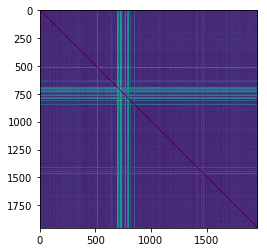

In [46]:
plt.imshow(asymmetrical_H_training)

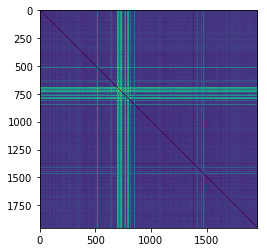

In [47]:
plt.imshow(symmetrical_H_training)

In [50]:
symmetrical_H_training = np.load(r'C:\phd\rpca\input\kl-divergence\symmetrical_H_training.dat')
symmetrical_H_validation = np.load(r'C:\phd\rpca\input\kl-divergence\symmetrical_H_validation.dat')
symmetrical_H_test = np.load(r'C:\phd\rpca\input\kl-divergence\symmetrical_H_test.dat')

In [ ]:
# H_training = np.load(r'C:\phd\rpca\input\kl-divergence\H_training.dat')
# H_validation = np.load(r'C:\phd\rpca\input\kl-divergence\H_validation.dat')
# H_test = np.load(r'C:\phd\rpca\input\kl-divergence\H_test.dat')

In [10]:
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

# lam_list = [0.01, 0.02, 0.03, 0.04]

In [52]:
dataset_types = ["training", "validation", "test"]

# RPCA parameters for experiments
maxIteration = 1000
verbose = True

for dataset_type in dataset_types:
    df = None
    if "training" == dataset_type:
        print("%s - using symmetrical_H_training" % dataset_type)
        df = symmetrical_H_training
    elif "validation" == dataset_type:
        print("%s - using symmetrical_H_validation" % dataset_type)
        df = symmetrical_H_validation
    else:
        print("%s - using symmetrical_H_test" % dataset_type)
        df = symmetrical_H_test

    nrows, ncols, maxRank, m, n, u, v, vecM, vecEpsilon = get_input_dataset(df)
    print("get_input_dataset returned nrows = %d, ncols = %d, maxRank = %d" % (nrows, ncols, maxRank))
    
    for lambda_multiplier in lam_list:    
        actual_lambda = get_scaled_lambda(nrows, ncols, lambda_multiplier)
        print('Now processing lambda multiplier = %4f and actual lambda = %5f' % (lambda_multiplier, actual_lambda))

        output_root_dir = get_symmetrical_output_root_dir(dataset_type)
        print("output_root_dir = %s" % output_root_dir)
                
        U, E, VT, S, B = sRPCA(m, n, u, v, vecM, vecEpsilon, maxRank, 
                           lam=actual_lambda, mu=None, rho=None, 
                           epsilon1=None, epsilon2=None, 
                           truncateK=0, SOff=False, maxIteration=maxIteration, verbose=verbose)
        filename_prefix = r"lambda_" + str(lambda_multiplier)
        U.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_U.dat'))
        E.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_E.dat'))
        VT.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_VT.dat'))
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_S.npz'), S) # compressed matrix
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_B.npz'), B) # compressed matrix

training - using symmetrical_H_training
get_input_dataset returned nrows = 1954, ncols = 1954, maxRank = 1954
Now processing lambda multiplier = 0.050000 and actual lambda = 0.001131
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   2.96e-03 1.00e-05   1.95e-04 1.00e-04 3.08e+00 4.78e-02
       18   7.84e-06 1.00e-05   5.13e-05 1.00e-04 3.08e+00 4.28e+00
Now processing lambda multiplier = 0.052600 and actual lambda = 0.001190
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   3.15e-03 1.00e-05   2.07e-04 1.00e-04 3.08e+00 4.78e-02
       18   8.51e-06 1.00e-05   5.55e-05 1.00e-04 3.08e+00 4.28e+00
Now processing lambda multiplier = 0.055600 and actual lambda = 0.001258
output_root_dir =


criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   3.30e-02 1.00e-05   1.71e-04 1.00e-04 3.08e+00 1.55e-02
       20   8.99e-03 1.00e-05   2.61e-04 1.00e-04 3.08e+00 4.78e-02
       30   1.29e-03 1.00e-05   1.05e-04 1.00e-04 3.08e+00 1.47e-01
       40   5.05e-05 1.00e-05   1.02e-04 1.00e-04 3.08e+00 4.28e+00
       44   7.97e-06 1.00e-05   3.36e-05 1.00e-04 3.08e+00 1.32e+01
Now processing lambda multiplier = 0.500000 and actual lambda = 0.011311
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   3.69e-02 1.00e-05   1.29e-04 1.00e-04 3.08e+00 1.55e-02
       20   1.97e-02 1.00e-05   2.90e-04 1.00e-04 3.08e+00 4.78e-02
       30   5.56e-03 1.00e-05   2.92e-04 1.00e-04 3.08e+00 1.47e-01
       40   8.84e-04 1.00e-05   2.72e-04 1.00e-04 3.08e+00 4.52e-01
     

       50   7.94e-04 1.00e-05   1.07e-04 1.00e-04 3.08e+00 4.52e-01
       60   2.33e-04 1.00e-05   1.09e-04 1.00e-04 3.08e+00 1.39e+00
       70   3.10e-05 1.00e-05   7.54e-05 1.00e-04 3.08e+00 1.32e+01
       72   8.40e-06 1.00e-05   4.42e-05 1.00e-04 3.08e+00 1.32e+01
Now processing lambda multiplier = 10.000000 and actual lambda = 0.226224
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.22e-02 1.00e-05   1.37e-04 1.00e-04 3.08e+00 1.55e-02
       20   2.32e-02 1.00e-05   1.13e-04 1.00e-04 3.08e+00 1.55e-02
       30   6.88e-03 1.00e-05   1.27e-04 1.00e-04 3.08e+00 4.78e-02
       40   1.84e-03 1.00e-05   2.63e-04 1.00e-04 3.08e+00 4.52e-01
       50   8.02e-04 1.00e-05   1.13e-04 1.00e-04 3.08e+00 4.52e-01
       60   2.36e-04 1.00e-05   1.10e-04 1.00e-04 3.08e+00 1.39e+00
       70   3.83e-05 1.00e-05   5.04e-05 1.00e-04 3.08e


criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   2.45e-02 1.00e-05   3.58e-04 1.00e-04 3.08e+00 2.56e-02
       20   4.87e-03 1.00e-05   2.42e-04 1.00e-04 3.08e+00 7.89e-02
       30   6.32e-04 1.00e-05   2.50e-04 1.00e-04 3.08e+00 7.46e-01
       40   1.81e-05 1.00e-05   5.23e-05 1.00e-04 3.08e+00 7.06e+00
       42   7.05e-06 1.00e-05   4.38e-05 1.00e-04 3.08e+00 2.17e+01
Now processing lambda multiplier = 0.200000 and actual lambda = 0.008918
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   3.33e-02 1.00e-05   4.32e-04 1.00e-04 3.08e+00 2.56e-02
       20   1.03e-02 1.00e-05   2.99e-04 1.00e-04 3.08e+00 7.89e-02
       30   1.68e-03 1.00e-05   2.93e-04 1.00e-04 3.08e+00 2.43e-01
       40   1.41e-04 1.00e-05   1.85e-04 1.00e-04 3.08e+00 2.30e+00
   

       10   3.40e-02 1.00e-05   1.77e-03 1.00e-04 3.08e+00 7.89e-02
       20   1.64e-02 1.00e-05   3.67e-04 1.00e-04 3.08e+00 7.89e-02
       30   1.12e-02 1.00e-05   2.09e-04 1.00e-04 3.08e+00 7.89e-02
       40   8.71e-03 1.00e-05   2.74e-04 1.00e-04 3.08e+00 2.43e-01
       50   3.90e-03 1.00e-05   3.01e-04 1.00e-04 3.08e+00 2.43e-01
       60   2.14e-03 1.00e-05   1.28e-04 1.00e-04 3.08e+00 2.43e-01
       70   1.03e-03 1.00e-05   3.22e-04 1.00e-04 3.08e+00 7.46e-01
       80   4.79e-04 1.00e-05   3.12e-04 1.00e-04 3.08e+00 2.30e+00
       90   1.41e-04 1.00e-05   1.00e-04 1.00e-04 3.08e+00 7.06e+00
      100   2.04e-05 1.00e-05   3.58e-05 1.00e-04 3.08e+00 6.68e+01
      102   7.76e-06 1.00e-05   8.85e-05 1.00e-04 3.08e+00 6.68e+01
Now processing lambda multiplier = 7.000000 and actual lambda = 0.312115
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon

Now processing lambda multiplier = 0.076900 and actual lambda = 0.003425
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   2.61e-02 1.00e-05   2.98e-04 1.00e-04 3.08e+00 2.46e-02
       20   1.59e-03 1.00e-05   2.56e-04 1.00e-04 3.08e+00 2.33e-01
       30   7.06e-06 1.00e-05   5.41e-05 1.00e-04 3.08e+00 2.08e+01
       30   7.06e-06 1.00e-05   5.41e-05 1.00e-04 3.08e+00 2.08e+01
Now processing lambda multiplier = 0.083300 and actual lambda = 0.003710
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   2.94e-02 1.00e-05   1.04e-04 1.00e-04 3.08e+00 7.99e-03
       20   2.29e-03 1.00e-05   1.35e-04 1.00e-04 3.08e+00 7.56e-02
       30   3.46e-05 1.00e-05   6.74e-05 1.00e-04 3.08e+00 2.20e+00
    

Now processing lambda multiplier = 2.000000 and actual lambda = 0.089087
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.85e-02 1.00e-05   3.75e-04 1.00e-04 3.08e+00 2.46e-02
       20   2.88e-02 1.00e-05   7.37e-04 1.00e-04 3.08e+00 7.56e-02
       30   1.64e-02 1.00e-05   3.44e-04 1.00e-04 3.08e+00 7.56e-02
       40   1.13e-02 1.00e-05   1.90e-04 1.00e-04 3.08e+00 7.56e-02
       50   7.36e-03 1.00e-05   1.23e-04 1.00e-04 3.08e+00 7.56e-02
       60   3.75e-03 1.00e-05   2.86e-04 1.00e-04 3.08e+00 2.33e-01
       70   2.01e-03 1.00e-05   1.06e-04 1.00e-04 3.08e+00 2.33e-01
       80   7.98e-04 1.00e-05   2.04e-04 1.00e-04 3.08e+00 7.15e-01
       90   2.24e-04 1.00e-05   1.32e-04 1.00e-04 3.08e+00 2.20e+00
      100   2.13e-05 1.00e-05   6.61e-05 1.00e-04 3.08e+00 2.08e+01
      103   9.81e-06 1.00e-05   4.30e-05 1.00e-04 3.08e+00 6

       90   2.11e-04 1.00e-05   1.15e-04 1.00e-04 3.08e+00 2.20e+00
      100   5.13e-05 1.00e-05   8.63e-05 1.00e-04 3.08e+00 6.77e+00
      110   7.73e-06 1.00e-05   5.38e-05 1.00e-04 3.08e+00 6.40e+01
      110   7.73e-06 1.00e-05   5.38e-05 1.00e-04 3.08e+00 6.40e+01
Now processing lambda multiplier = 10.000000 and actual lambda = 0.445435
output_root_dir = C:\phd\rpca\output\symmetrical-kl-divergence\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.31e-02 1.00e-05   1.52e-03 1.00e-04 3.08e+00 7.56e-02
       20   1.34e-02 1.00e-05   3.04e-04 1.00e-04 3.08e+00 7.56e-02
       30   8.97e-03 1.00e-05   1.47e-04 1.00e-04 3.08e+00 7.56e-02
       40   6.36e-03 1.00e-05   4.65e-04 1.00e-04 3.08e+00 2.33e-01
       50   3.92e-03 1.00e-05   2.08e-04 1.00e-04 3.08e+00 2.33e-01
       60   2.41e-03 1.00e-05   1.54e-04 1.00e-04 3.08e+00 2.33e-01
       70   1.46e-03 1.00e-05   3.66e-04 1.00e-04 3.08e+00 

In [31]:
np.savetxt(r'C:\phd\rpca\debug\H_validation.csv', H_validation, delimiter=',')
np.savetxt(r'C:\phd\rpca\debug\H_test.csv', H_test, delimiter=',')

In [1]:
# err = np.ones(H_training.shape)*1e-6
# m, n, u, v, vecM, vecEpsilon = denseToSparse(H_training, err)

# maxRank = np.min(H_training.shape)
# maxIteration = 1000
# verbose = True
# root_dir = r'C:\phd\output\rpca\sp500\kl-divergence'

# for _lam in lam_list:    
#     scaled_lambda = get_scaled_lambda(H_training.shape[0], H_training.shape[1], _lam)
#     print()
#     print('Now processing _lam = %4f and scaled lambda = %5f' % (_lam, scaled_lambda))
#     U, E, VT, S, B = sRPCA(m, n, u, v, vecM, vecEpsilon, maxRank, 
#                        lam=scaled_lambda, mu=None, rho=None, 
#                        epsilon1=None, epsilon2=None, 
#                        truncateK=0, SOff=False, maxIteration=maxIteration, verbose=verbose)
#     filename_prefix = r"lambda_" + str(_lam)
#     U.dump(get_full_path_2_save(root_dir, filename_prefix + '_U.dat'))
#     E.dump(get_full_path_2_save(root_dir, filename_prefix + '_E.dat'))
#     VT.dump(get_full_path_2_save(root_dir, filename_prefix + '_VT.dat'))
#     scipy.sparse.save_npz(get_full_path_2_save(root_dir, filename_prefix + '_S.npz'), S) # compressed matrix
#     scipy.sparse.save_npz(get_full_path_2_save(root_dir, filename_prefix + '_B.npz'), B) # compressed matrix

### Plot KL Divergence 

In [42]:
# L_training = U * np.diag(E) * VT
dt1 = datetime.datetime(2006, 1, 4, 0, 0)
dt2 = datetime.datetime(2013, 10, 8, 0, 0)
# print("Start Unix Timestamp: ",(time.mktime(dt1.timetuple())))
# print("End Unix Timestamp: ",(time.mktime(dt2.timetuple())))

# Create your x-limits. Using two of your unix timestamps you first
# create a list of datetime.datetime objects using map.
y_lims = list(map(datetime.datetime.fromtimestamp, [1381204800, 1136350800]))

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
y_lims = mdates.date2num(y_lims)

x_lims = [0, 548]

In [57]:
def get_xlims_ylims(df):
    date_object = datetime.datetime.strptime(df.index[0], '%m/%d/%Y')
    dt_start = int(time.mktime(date_object.timetuple()))
    
    date_object = datetime.datetime.strptime(df.index[-1], '%m/%d/%Y')
    dt_end = int(time.mktime(date_object.timetuple()))

    # Create your x-limits. Using two of your unix timestamps you first
    # create a list of datetime.datetime objects using map.
    y_lims = list(map(datetime.datetime.fromtimestamp, [dt_start, dt_end]))

    # You can then convert these datetime.datetime objects to the correct
    # format for matplotlib to work with.
    y_lims = mdates.date2num(y_lims)

    x_lims = [0, df.shape[1]]
    
    return x_lims, y_lims

def load_matrices(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    
    u_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_U.dat')
    e_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_E.dat')
    vt_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_VT.dat')
    
    U = np.load(u_file_path)
    E = np.load(e_file_path)
    VT = np.load(vt_file_path)
    
    return sparse_matrix, dense_matrix, U, E, VT

# def plot_matrices(M, root_dir, lam, vmin, vmax):
#     S, D, U, E, VT = load_matrices(root_dir, lam)
#     fig, axes = plt.subplots(ncols=3, figsize = (20, 6)) # plt.figure(figsize=(20,10))
#     axes[0].imshow(M, vmin=vmin, vmax=vmax, aspect='auto', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]])
#     axes[0].set_title('Original Training Matrix')
#     axes[0].yaxis_date()
#     date_format = mdates.DateFormatter('%m/%d/%Y')
#     axes[0].yaxis.set_major_formatter(date_format)

#     L = U * np.diag(E) * VT
    
#     axes[1].imshow(L, vmin=vmin, vmax=vmax, aspect='auto', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]])
#     axes[1].set_title('Low Rank Training Matrix L lambda =' + str(lam))
#     axes[1].yaxis_date()
#     axes[1].yaxis.set_major_formatter(date_format)

#     axes[2].imshow(D, vmin=vmin, vmax=vmax, aspect='auto', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]])
#     axes[2].set_title('Sparse Training Matrix lambda =' + str(lam))
#     axes[2].yaxis_date()
#     axes[2].yaxis.set_major_formatter(date_format)

def plot_symmetrical_matrices(M, root_dir, lam, x_lims, y_lims, vmin=-0.02, vmax=0.02):
    plot_asymmetrical_matrices(M, root_dir, lam, x_lims, y_lims, vmin, vmax)

def plot_asymmetrical_matrices(M, root_dir, lam, x_lims, y_lims, vmin=-0.02, vmax=0.02):
    S, D, U, E, VT = load_matrices(root_dir, lam)
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].imshow(M, vmin=vmin, vmax=vmax, aspect='auto', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]])
    axes[0].set_title('Original Training Matrix')
    axes[0].yaxis_date()
    date_format = mdates.DateFormatter('%m/%d/%Y')
    axes[0].yaxis.set_major_formatter(date_format)

    L = U * np.diag(E) * VT
    
    axes[1].imshow(L, vmin=vmin, vmax=vmax, aspect='auto', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]])
    axes[1].set_title('Low Rank Training Matrix L lambda =' + str(lam))
    axes[1].yaxis_date()
    axes[1].yaxis.set_major_formatter(date_format)

    axes[2].imshow(D, vmin=vmin, vmax=vmax, aspect='auto', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]])
    axes[2].set_title('Sparse Training Matrix lambda =' + str(lam))
    axes[2].yaxis_date()
    axes[2].yaxis.set_major_formatter(date_format)    

In [56]:
# plt.rcParams.update({'figure.max_open_warning': 0})
# root_dir = r'C:\phd\output\rpca\sp500\kl-divergence'
# for lam in lam_list:
#     plot_matrices(H_training, root_dir, lam, 0, 66)

The probablities are smaller in this case.  The items in each bin is divided by the number of items in the bin.  This is different from adding all the bins, which total 1 in both the cases.  This case is about should each ticker have the same probability or the same total probability.

In [74]:
# plt.rcParams.update({'figure.max_open_warning': 0})
# root_dir = r'C:\phd\output\rpca\sp500\probabilities'
# H_training_small_pr = np.load(r'C:\phd\input\rpca\H_training.dat')

# for lam in lam_list:
#     plot_matrices(H_training_small_pr, root_dir, lam, 0, 0.006)

In [45]:
np.min(asymmetrical_H_training)

-35.93748843769802

In [55]:
# plt.rcParams.update({'figure.max_open_warning': 0})
# root_dir = r'C:\phd\rpca\output\asymmetrical-kl-divergence\training'
# for lam in lam_list:
#     plot_matrices(asymmetrical_H_training, root_dir, lam, 0, 66)

In [47]:
np.savetxt(r'C:\phd\rpca\debug\asymmetrical_H_training.csv', asymmetrical_H_training, delimiter=',')

In [60]:
np.std(asymmetrical_H_training)

49.2121681863602

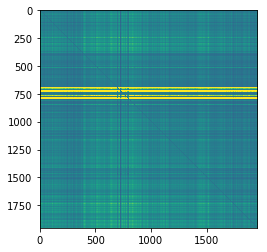

In [61]:
plt.imshow(asymmetrical_H_training, vmin=-39, vmax=60)

In [54]:
np.max(symmetrical_H_training)

4.59324517071566

In [59]:
# plt.rcParams.update({'figure.max_open_warning': 0})
# output_root_dir = get_symmetrical_output_root_dir("training")
# x_lims, y_lims = get_xlims_ylims(m_training_kl)
# symmetrical_H_training = np.load(r'C:\phd\rpca\input\kl-divergence\symmetrical_H_training.dat')
# lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
#             0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
#             6, 7, 8, 9, 10]
# for lambda_multiplier in lam_list: 
#     plot_symmetrical_matrices(symmetrical_H_training, output_root_dir, lambda_multiplier, x_lims, y_lims, 0, 2)